
### 구글 드라이브 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### 패키지 Import

In [2]:
# !pip install tensorflow==2.4.1
# !pip install numpy==1.19.2
import tensorflow as tf
import numpy as np
print(tf.__version__, np.__version__)

2.9.2 1.21.6


In [3]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM,Dropout,Dense,TimeDistributed,Conv1D,MaxPooling1D,Flatten,BatchNormalization, Activation
from tensorflow.keras import backend as K

In [4]:
from tqdm import tqdm
from numpy import fromfile
from os import listdir
from os.path import isfile, join

대회 평가 지표 F1_Score 정의

In [5]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

매 초 각 채널의 signal값 100만개를 모두 모델에 넣을 수 없으므로 19개 feature로 extract

In [ ]:
def feature_extractor(x): #input_shape(1,000,000(microsec)) output_shape(57)
  output = []
  mean = x.mean()
  std = x.std() 
  std_top = mean + std 
  std_bot = mean - std
  percentil_calc = np.percentile(x, [0, 1, 25, 50, 75, 99, 100]) 
  max_range = percentil_calc[-1] - percentil_calc[0] # this is the amplitude of the chunk
  relative_percentile = percentil_calc - mean # maybe it could heap to understand the asymmetry
  output.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]),percentil_calc, relative_percentile]))
  return np.asarray(output)

피처 다변화를 위하여 FFT 진행

In [ ]:
from numpy.fft import *
from scipy import fftpack

frequency 값 1e7미만의 노이즈 제거 함수

In [ ]:
def denoise(s, threshold=1e7):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

frequency 값 1e6미만의 lowpass 시그널 획득 함수

In [ ]:
def low_pass(s, threshold=1e6):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

frequency 값 1e7 초과의 highpass 시그널 획득 함수

In [ ]:
def high_pass(s, threshold=1e7):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies < threshold] = 0
    return irfft(fourier)

폴더로부터 매 초 각 채널의 .dat 파일을 읽어 denoise, lowpass, highpass 3개의 시그널로 분해 후 각각 위의 19개 feature로 extract 하여 concatenate하였다.
각각 다른 .ipynb 파일을 작성하여 진행한 후 로컬에 저장함

아래는 denoising 코드

In [ ]:
def prep_data(name, train=True, sec=360):
  if train:
    dir = 'data'
  else:
    dir = 'test_data'
  n_feature = 19
  n_channel = 3
  n_seconds = sec
  output = []
  channels = ["channel1.dat", "channel2.dat", "channel3.dat"]
  seconds = [f"{x}seconds" for x in range(1, n_seconds+1)]
  rootPath = f'./{name}'
  os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/{dir}/{name}")
  for folderPath in tqdm(seconds):
    temp = np.array([])
    for channelPath in channels:
      data = fromfile(join(rootPath,folderPath,channelPath), np.float64) * 1000 #mV 단위로 전환
      data = denoise(data)  #denosing
      temp = np.append(temp, feature_extractor(data)).reshape(-1, n_feature)
    output.append(temp)
  output = np.asarray(output).reshape(-1, n_feature, n_channel)
  return output  

정답 레이블 작성 후 저장

In [12]:
train_y = np.array([0]*119 + [1]*241 + [0]*120 + [1]*240 + [0]*120 + [1]*240 + [0]*120 + [1]*240).reshape(4,-1)
np.save("/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/np/train_y.npy", train_y)

로컬로부터 위에서 preprocessing한(FFT 및 FE) train data를 불러옴

In [14]:
import os
os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/np_concat")
train_X = np.load("train_X.npy")
train_y = np.load("train_y.npy")

shape은 4개 environment, 360초, 57개의 feature, 3개 채널을 의미함

In [15]:
print(train_X.shape, train_y.shape)

(4, 360, 57, 3) (4, 360)


train test split

In [16]:
from sklearn.model_selection import train_test_split
tX = []
ty = []
vX = []
vy = []
for i in range(4):
  temp_train_X, temp_val_X, temp_train_y, temp_val_y = train_test_split(train_X[i], train_y[i], test_size=0.1, random_state=11)
  tX.append(temp_train_X)
  ty.append(temp_train_y)
  vX.append(temp_val_X)
  vy.append(temp_val_y)
train_X = np.asarray(tX)
train_y = np.asarray(ty)
val_X = np.asarray(vX)
val_y = np.asarray(vy)

In [17]:
val_X[0].shape

(36, 57, 3)

In [18]:
verbose, epochs, batch_size = True, 10, 30

3개 채널에 대해 잠재 Feature Extracting을 위한 CNN Layer와 Classification을 위한 LSTM 레이어로 구성된 모델 Build

In [19]:
# define model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=1, activation='relu', input_shape=(57, 3)))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 57, 256)           1024      
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 256)           196864    
                                                                 
 dropout (Dropout)           (None, 55, 256)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 53, 256)           196864    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 256)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               142800    
                                                        

4개 environment에 대해 학습 진행

In [20]:
history_list = []
for i in range(4):
  history_list.append(model.fit(train_X[i], train_y[i], validation_data=(val_X[i], val_y[i]), shuffle=True,
                          epochs=epochs, batch_size=batch_size, verbose=verbose))

Epoch 1/10
11/11 [==============================] - 11s 425ms/step - loss: 0.2995 - f1_score: 0.9268 - val_loss: 0.0249 - val_f1_score: 1.0000
Epoch 2/10
11/11 [==============================] - 2s 151ms/step - loss: 0.0362 - f1_score: 0.9980 - val_loss: 0.0031 - val_f1_score: 1.0000
Epoch 3/10
11/11 [==============================] - 2s 151ms/step - loss: 0.0270 - f1_score: 0.9978 - val_loss: 0.0012 - val_f1_score: 1.0000
Epoch 4/10
11/11 [==============================] - 2s 153ms/step - loss: 0.0161 - f1_score: 0.9978 - val_loss: 0.0011 - val_f1_score: 1.0000
Epoch 5/10
11/11 [==============================] - 2s 150ms/step - loss: 0.0223 - f1_score: 0.9978 - val_loss: 0.0015 - val_f1_score: 1.0000
Epoch 6/10
11/11 [==============================] - 2s 149ms/step - loss: 0.0161 - f1_score: 0.9977 - val_loss: 0.0015 - val_f1_score: 1.0000
Epoch 7/10
11/11 [==============================] - 2s 148ms/step - loss: 0.0155 - f1_score: 0.9980 - val_loss: 0.0020 - val_f1_score: 1.0000
Epoch

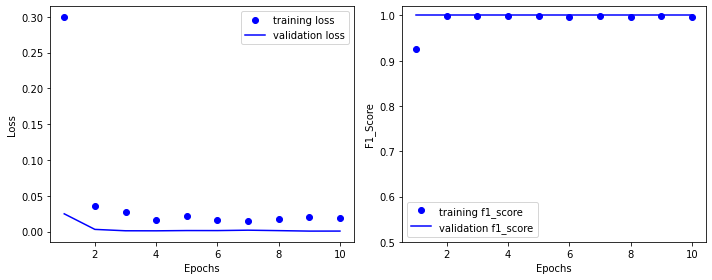

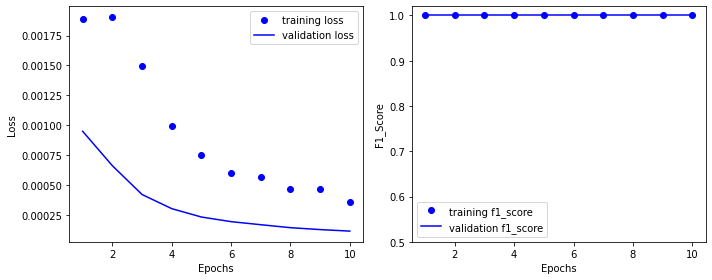

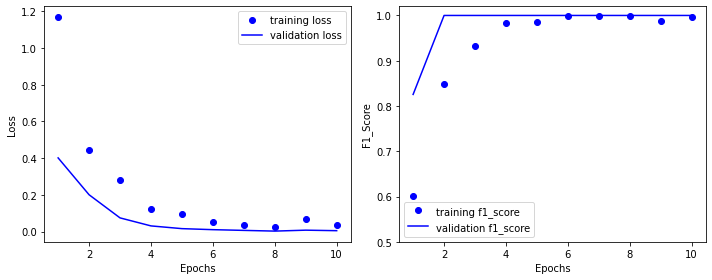

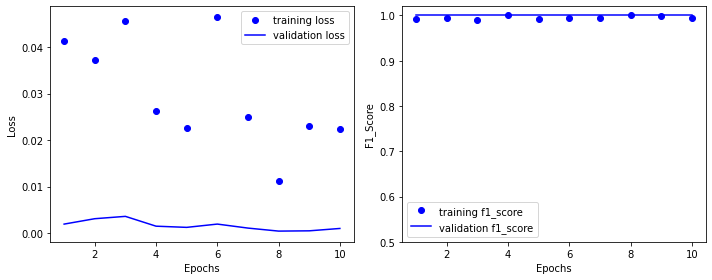

In [21]:
import matplotlib.pyplot as plt

for history in history_list:
  history_dict= history.history

  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  accuracy = history_dict['f1_score']
  val_accuracy = history_dict['val_f1_score']

  epochs = range(1, len(loss)+1)

  plt.figure(figsize=(10, 4))

  plt.subplot(121)


  plt.plot(epochs, loss, 'bo',label='training loss')
  plt.plot(epochs, val_loss, 'b', label='validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss') 
  plt.legend()

  plt.subplot(122)


  plt.plot(epochs, accuracy, 'bo',label='training f1_score')
  plt.plot(epochs, val_accuracy, 'b', label='validation f1_score')
  plt.xlabel('Epochs')
  plt.ylabel('F1_Score')
  plt.ylim((0.5,1.02)) 
  plt.legend()

  plt.tight_layout()
  plt.show()

test set에 대해 Preprocessing(FFT, FE)한 데이터 자료를 로컬에서 불러옴

In [23]:
os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/np_{ptype}")
dataset1_X = np.load("Dataset1_X.npy")
dataset2_X = np.load("Dataset2_X.npy")
dataset3_X = np.load("Dataset3_X.npy")

In [24]:
dataset3_X.shape

(95, 57, 3)

In [25]:
preds1 = model.predict(dataset1_X)
preds2 = model.predict(dataset2_X)
preds3 = model.predict(dataset3_X)

3/3 [==============================] - 0s 37ms/step


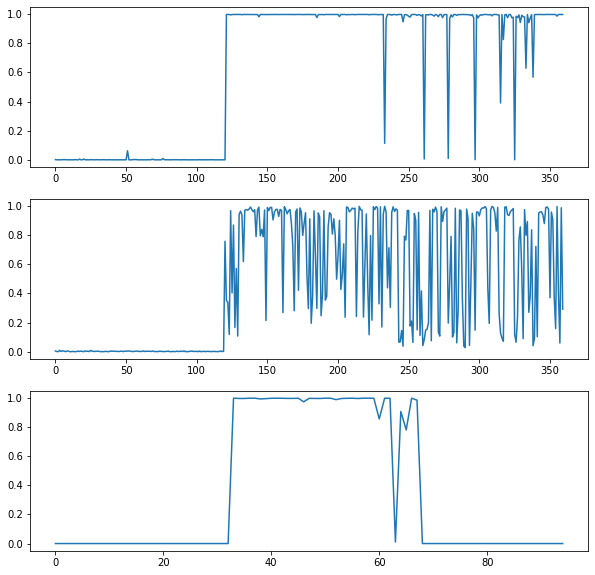

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(311)
plt.plot(preds1)
plt.subplot(312)
plt.plot(preds2)
plt.subplot(313)
plt.plot(preds3)

클래스 분류

In [27]:
threshold = 0.5
threshpreds1 = (preds1>threshold)*1
threshpreds2 = (preds2>threshold)*1
threshpreds3 = (preds3>threshold)*1

In [28]:
threshpreds2.T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 

submission을 위해 로컬 저장

In [29]:
os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/np_localization")
np.save("dataset1_bool.npy", threshpreds1)
np.save("dataset2_bool.npy", threshpreds2)
np.save("dataset3_bool.npy", threshpreds3)

In [30]:
threshpreds1 = np.array(list(map(lambda x: "Y" if int(x) else "N", list(threshpreds1))))
threshpreds2 = np.array(list(map(lambda x: "Y" if int(x) else "N", list(threshpreds2))))
threshpreds3 = np.array(list(map(lambda x: "Y" if int(x) else "N", list(threshpreds3))))

In [31]:
os.chdir(f"/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/submission")
np.save("dataset1_y.npy", threshpreds1)
np.save("dataset2_y.npy", threshpreds2)
np.save("dataset3_y.npy", threshpreds3)

In [32]:
model.save('/content/drive/MyDrive/지하배관 안전관리 빅데이터 활용 경진대회/submission/leakage_detection.h5')